In [26]:
import os
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt

from tqdm import tqdm

In [3]:
data_path = "/kaggle/input/asl-signs"
print(os.path.isdir(data_path))

True


In [4]:
# train.csv file
df = pd.read_csv(f"{data_path}/train.csv")
df.head()

,path,participant_id,sequence_id,sign
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie


In [5]:
len(df)

94477

In [6]:
files = glob(f"{data_path}/train_landmark_files/*/*")

In [7]:
len(files)

94477

Number of rows in the `train.csv` file is equal to the number of parquet files.

In [8]:
df.participant_id.value_counts()

49445    4968
61333    4900
36257    4896
16069    4848
26734    4841
55372    4826
2044     4810
37779    4782
32319    4753
29302    4722
22343    4677
53618    4656
37055    4648
28656    4563
62590    4563
34503    4545
27610    4275
25571    3865
18796    3502
4718     3499
30680    3338
Name: participant_id, dtype: int64

In [9]:
df.sequence_id.value_counts()

1000035562    1
3581948762    1
3582491179    1
3582420976    1
3582370385    1
             ..
2290034600    1
2290026468    1
2289951796    1
2289904716    1
999962374     1
Name: sequence_id, Length: 94477, dtype: int64

<AxesSubplot:>

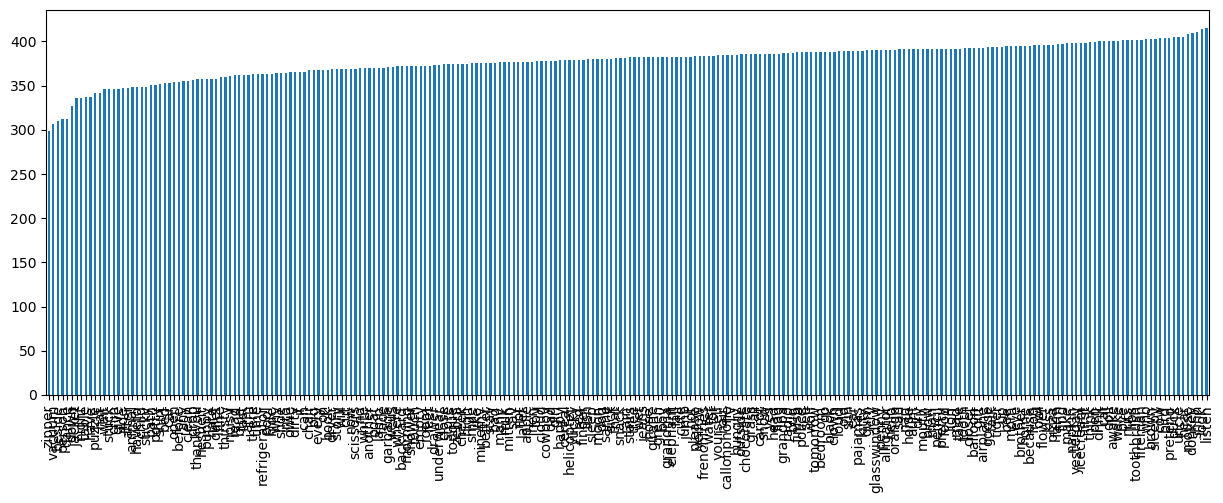

In [10]:
plt.figure(figsize=(15,5))
df.sign.value_counts().sort_values().plot(kind = 'bar')

The class distribution doesn't look scary.

In [11]:
file_path = files[0]
file_path

'/kaggle/input/asl-signs/train_landmark_files/36257/3762317508.parquet'

In [14]:
landmark_df = pd.read_parquet(file_path)
landmark_df

,frame,row_id,type,landmark_index,x,y,z
0,0,0-face-0,face,0,0.536712,0.421679,-0.054983
1,0,0-face-1,face,1,0.532607,0.388884,-0.064112
2,0,0-face-2,face,2,0.535190,0.405216,-0.043147
3,0,0-face-3,face,3,0.515270,0.369050,-0.034260
4,0,0-face-4,face,4,0.530208,0.380113,-0.063684
...,...,...,...,...,...,...,...
24973,45,45-right_hand-16,right_hand,16,NaN,NaN,NaN
24974,45,45-right_hand-17,right_hand,17,NaN,NaN,NaN
24975,45,45-right_hand-18,right_hand,18,NaN,NaN,NaN
24976,45,45-right_hand-19,right_hand,19,NaN,NaN,NaN


In [16]:
ROWS_PER_FRAME = 543  # number of landmarks per frame

n_frames = int(len(landmark_df) / ROWS_PER_FRAME)
n_frames

46

In [17]:
frame_df = landmark_df.groupby("frame")

In [20]:
for frame, tmp_df in frame_df:
    break

In [23]:
tmp_df.type.value_counts()

face          468
pose           33
left_hand      21
right_hand     21
Name: type, dtype: int64

* "hand landmark model performs precise keypoint localization of 21 3D hand-knuckle coordinates" ([Source](https://google.github.io/mediapipe/solutions/hands.html#hand-landmark-model))

* "MediaPipe Pose is a ML solution for high-fidelity body pose tracking, inferring 33 3D landmarks" ([Source](https://google.github.io/mediapipe/solutions/pose.html))

* "MediaPipe Face Mesh is a solution that estimates 468 3D face landmarks in real-time even on mobile devices." ([source](https://google.github.io/mediapipe/solutions/face_mesh.html))


For each parquet, there are N frames. Each frame is represented by normalized (x, y, z) values of size 543. The representation is landmarks of face, left hand, body pose and right hand in that order as predicted by MediaPipe pipeline.

Each data point can be represented as (N, 543, x, y, z). We can also include `landmark_index` and `type` in the modeling process. Note that we can ignore `z` since the MediaPipe model is not well trained for depth estimation.

Each parquet file maps to a single class (250 classes in total).

Ideas:

* Model it sequentially. LSTMs can be used but how? How to design the data pipeline? 
* Have a linear head on top with classification loss to optimize for.
* Stratified train test split (label = `sign`)

In [27]:
# Number of frames - stats

frames = []

for file_path in tqdm(files):
    landmark_df = pd.read_parquet(file_path)
    n_frames = int(len(landmark_df) / ROWS_PER_FRAME)
    frames.append(n_frames)
    
frames = np.array(frames)

100%|██████████| 94477/94477 [40:33<00:00, 38.83it/s]  


In [34]:
frames.mean(), frames.std(), frames.min(), frames.max(), np.median(frames)

(37.93502122209638, 44.1768352150635, 2, 537, 22.0)

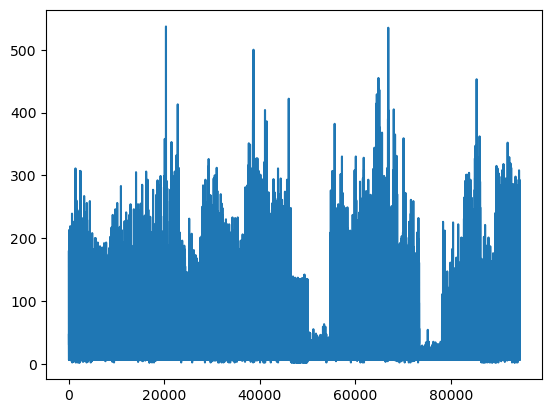

In [35]:
plt.plot(frames)

In [39]:
np.where(frames == 2)

(array([  700,  1425,  1757,  2087,  2123,  2296,  3713,  4573,  9457,
        16810, 16912, 17415, 17834, 23528, 25827, 28511, 29691, 31264,
        31481, 32006, 32389, 33523, 33805, 34726, 38600, 40054, 40778,
        40934, 41117, 42301, 43821, 46634, 46718, 46840, 46841, 47063,
        47075, 47087, 47090, 47173, 47184, 47237, 47282, 47546, 47618,
        47688, 47846, 47915, 47983, 48012, 48105, 48148, 48187, 48326,
        48350, 48365, 48443, 48591, 48673, 48998, 49016, 49137, 49292,
        49410, 49549, 49585, 49662, 49688, 49702, 49726, 49741, 49831,
        49842, 53954, 59088, 61080, 61553, 61830, 69260, 70359, 71220,
        71562, 73156, 86464, 86718, 86896, 87038, 87236, 87252, 87628,
        88120, 88436, 88676, 88778, 89279, 89434, 89570, 89978, 92846,
        93338, 93385, 93682, 93994]),)

In [41]:
a = pd.read_parquet(files[1425])
a

,frame,row_id,type,landmark_index,x,y,z
0,0,0-face-0,face,0,0.449789,0.515869,-0.046844
1,0,0-face-1,face,1,0.440825,0.465458,-0.067779
2,0,0-face-2,face,2,0.446301,0.480705,-0.043101
3,0,0-face-3,face,3,0.418987,0.439424,-0.041576
4,0,0-face-4,face,4,0.436948,0.455049,-0.068871
...,...,...,...,...,...,...,...
1081,1,1-right_hand-16,right_hand,16,NaN,NaN,NaN
1082,1,1-right_hand-17,right_hand,17,NaN,NaN,NaN
1083,1,1-right_hand-18,right_hand,18,NaN,NaN,NaN
1084,1,1-right_hand-19,right_hand,19,NaN,NaN,NaN


In [42]:
len(a) / 543

2.0

In [47]:
df["num_frames"] = frames

In [48]:
df

,path,participant_id,sequence_id,sign,num_frames
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow,46
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait,6
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud,20
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird,20
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie,180
...,...,...,...,...,...
94472,train_landmark_files/53618/999786174.parquet,53618,999786174,white,6
94473,train_landmark_files/26734/999799849.parquet,26734,999799849,have,23
94474,train_landmark_files/25571/999833418.parquet,25571,999833418,flower,121
94475,train_landmark_files/29302/999895257.parquet,29302,999895257,room,21


In [49]:
import wandb
wandb.__version__

'0.13.10'

In [50]:
wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [51]:
run = wandb.init(project="asl_sign")
wandb.log({"train.csv": wandb.Table(dataframe=df)})
run.finish()

wandb: Currently logged in as: ayush-thakur. Use `wandb login --relogin` to force relogin
